# 05 SPDE on athena

Open this notebook after 05_SPDE_on_fenics_solver.ipynb.

The Active Subspaces can be found also for vectorial output of interests. In this case the codomain can be enriched with a metric and a priori error bounds of the mean square error of the ridge approximation can be found similarly. This test case was remodelled from [Zahm, Olivier, Paul G. Constantine, Clementine Prieur, and Youssef M. Marzouk. "Gradient-based dimension reduction of multivariate vector-valued functions."](https://epubs.siam.org/doi/pdf/10.1137/18M1221837).

This notebook uses [GPy](https://github.com/SheffieldML/GPy).

### The quantities related to the input space are:
1. $m\in\mathbb{N}$ the dimension of the input space,
2. $(\Omega, \mathcal{F}, P)$ the probability space,
3. $\mathbf{X}:(\Omega, \mathcal{F},P)\rightarrow \mathbb{R}^m$, the absolutely continuous random vector representing the parameters,
4. $\rho:\mathbb{R}^{m}\rightarrow \mathbb{R}$, the probability density of $\mathbf{X}$ with support $\mathcal{X}\subset\mathbb{R}^{m}$.

### The quantities related to the vectorial output are:
1. $d\in\mathbb{N}$ the dimension of the output space,
2. $V=(\mathbb{R}^{d},R_{V})$ the Euclidean space with metric $R_{V}\in\mathcal{M}(d\times d)$ and norm
$$
\lVert\mathbf{x}\rVert^{2}_{R_{V}}=\mathbf{x}^{T}R_{V}\mathbf{x}
$$
3. $f:\mathcal{X}\subset\mathbb{R}^{m}\rightarrow V$, the quantity of interest,
2. $Df:\mathcal{X}\subset\mathbb{R}^{m}\rightarrow \mathbb{R}^{d\times m}$, the jacobian matrix of $f$.

### Reduction with Active Subspaces
The correlation matrix of the gradients of $f$ is approximated with the Monte Carlo method. The the eigendecomposition of the resulting symmetric positive definite matrix is performed

$$ \normalsize
\mathbf{C} = \int_{\mathcal{X}} (D_{\mathbf{x}} f)^{T} R_{V}( D_{\mathbf{x}} f ) \, d \rho(\mathbf{x}) \approx \frac{1}{M}\sum_{i=1}^{M} (D_{\mathbf{x}} f)^{T} R_{V}( D_{\mathbf{x}} f ) = \mathbf{W} \mathbf{\Lambda} \mathbf{W}^T
$$

The Active and Inactive subspaces decompose the original domain in a direct product.

$$\large
\mathbf{\Lambda} =   \begin{bmatrix} \mathbf{\Lambda}_1 & \\
                                     &
                                     \mathbf{\Lambda}_2\end{bmatrix},
\qquad
\mathbf{W} = \left [ \mathbf{W}_1 \quad \mathbf{W}_2 \right ],
\qquad
\mathbf{W}_1 \in \mathbb{R}^{m\times r}
\qquad
\mathbf{W}_2 \in \mathbb{R}^{m\times m-r}
$$

where $r$ is the dimension of the Active Subspace and $\mathbf{\Lambda}$ is the diagonal matrix of decreasingly ordered eigenvalues $\lambda_{1},\dots,\lambda_{m}$. Then the input data can be decomposed as

$$\large
\mathbf{x} = \mathbf{W}\mathbf{W}^T\mathbf{x} =
\mathbf{W}_1\mathbf{W}_1^T\mathbf{x} +
\mathbf{W}_2\mathbf{W}_2^T\mathbf{x} = \mathbf{W}_1 \mathbf{y} +
\mathbf{W}_2 \mathbf{z}.
$$

### Model functions
The outputs of interest in this tutorial are 

1. **scalar output**: the mean of the solution to the PDE described in 05_SPDE_on_fenics_solver restricted to the outflow boundary

$$
f_{res}:\chi\subset\mathbb{R}^{m}\rightarrow\mathbb{R},\qquad f(\boldsymbol{\mu})=\frac{1}{N}\sum^{N}_{i\in\{1,\dots,\text{ndofs}\} \\\ s.t.\ \text{i-th}\ \text{dof}\in\partial\Omega_{out}}(u_{\boldsymbol{\mu}})_{i}\approx\int_{\partial\Omega_{out}}u_{\boldsymbol{\mu}}(\mathbf{x})\ d\mathbf{x}
$$

2. **vectorial output**: the whole solution $u_{\boldsymbol{\mu}}$ to the PDE described in 05_SPDE_on_fenics_solver on the finite element space spanned by first order Lagrange shape functions

$$
f:\chi\subset\mathbb{R}^{m}\rightarrow\mathbb{R}^{d},\qquad f(\boldsymbol{\mu}) = (u_{\boldsymbol{\mu}})_{i\in\{1,\dots,\text{ndofs}\}}
$$

### Metric
In this tutorial the metric is derived from the discretization of the Hilbert space $H^{1}(\Omega)$ where the solution is found

$$\normalsize
(R_{V})_{ij}= a(\phi_{i},\phi_{j})=\int_{\Omega}\nabla\phi_{i}(\mathbf{x})\cdot\nabla\phi_{j}(\mathbf{x})\ d\mathbf{x}\qquad\forall i,j\in\{1,\dots,\text{ndofs}\}
$$

where $\text{ndofs}$ is the number of degrees of freedom, $R_{V}\in\mathcal{M}(d\times d)$ is the matrix representing the metric associated to the energy scalar product $a(\cdot,\cdot)$ with respect to the basis of Lagrange shape functions $\{\phi\}_{i\in\{1,\dots,\text{ndofs}\}}\subset H^{1}(\Omega)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import GPy
from scipy.stats import multivariate_normal
from scipy.linalg import sqrtm
from collections import namedtuple
from functools import partial
from pathlib import Path
import os

from athena.active import ActiveSubspaces
from athena.utils import Normalizer

In [3]:
p = Path("05_SPDE/outputs_res.npy")
with p.open('rb') as fi:
    fsz = os.fstat(fi.fileno()).st_size
    out = np.load(fi)
    while fi.tell() < fsz:
        out = np.vstack((out, np.load(fi)))
f_ = out
print("Output shape", f_.shape)

p = Path("05_SPDE/outputs.npy")
with p.open('rb') as fi:
    fsz = os.fstat(fi.fileno()).st_size
    out_ = np.load(fi)
    while fi.tell() < fsz:
        out_ = np.vstack((out_, np.load(fi)))
fa_ = out_
print("Output shape", fa_.shape)

p = Path("05_SPDE/inputs.npy")
with p.open('rb') as fi:
    fsz = os.fstat(fi.fileno()).st_size
    out1 = np.load(fi)
    while fi.tell() < fsz:
        out1 = np.vstack((out1, np.load(fi)))
x_ = out1
print("Input shape", x_.shape)

p = Path("05_SPDE/gradients_res.npy")
with p.open('rb') as fi:
    fsz = os.fstat(fi.fileno()).st_size
    out2 = np.load(fi)
    while fi.tell() < fsz:
        out2 = np.vstack((out2, np.load(fi)))
df_ = out2
print("Gradients shape", df_.shape)

p = Path("05_SPDE/gradients.npy")
with p.open('rb') as fi:
    fsz = os.fstat(fi.fileno()).st_size
    out2_ = np.load(fi)
    while fi.tell() < fsz:
        out2_ = np.vstack((out2_, np.load(fi)))
dfa_ = out2_
print("Gradients shape", dfa_.shape)

p = Path("data/metric.npy")
with p.open('rb') as fi:
    fsz = os.fstat(fi.fileno()).st_size
    out3 = np.load(fi)
    while fi.tell() < fsz:
        out3 = np.vstack((out3, np.load(fi)))
metric = out3
print("Metric shape", metric.shape)

Output shape (500, 1)
Output shape (500, 1668)
Input shape (500, 10)
Gradients shape (500, 10)
Gradients shape (834000, 10)
Metric shape (1668, 1668)


In [4]:
#simulation parameters
np.random.seed(42)
n_samples = x_.shape[0]
input_dim = x_.shape[1]
d = fa_.shape[1]
dim = 1

#process data
x, f, df = x_, f_, df_
print("data", x.shape, f.shape, df.shape)

data (500, 10) (500, 1) (500, 10)


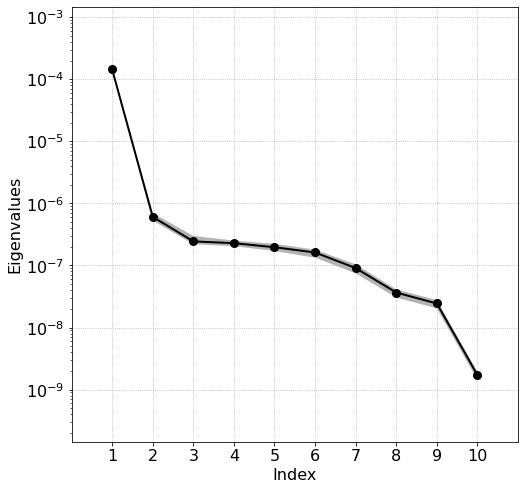

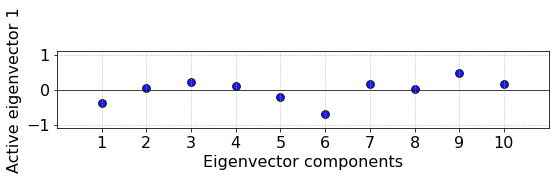

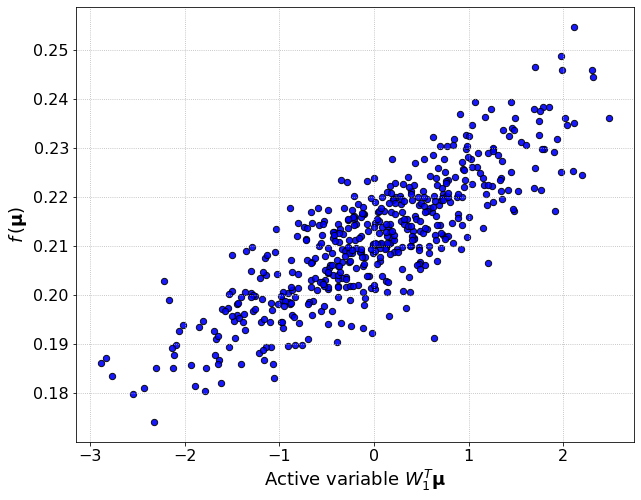

In [5]:
#AS
ss = ActiveSubspaces()
ss.compute(inputs=x, outputs=f, gradients=df)
ss.partition(1)
ss.plot_eigenvalues()
ss.plot_eigenvectors()
ss.plot_sufficient_summary(inputs=x, outputs=f)

## Active Subspaces with vectorial outputs

In [6]:
#process data
x, f, df = x_, fa_, dfa_.reshape(n_samples, d, input_dim)
print("data", x.shape, f.shape, df.shape)

data (500, 10) (500, 1668) (500, 1668, 10)


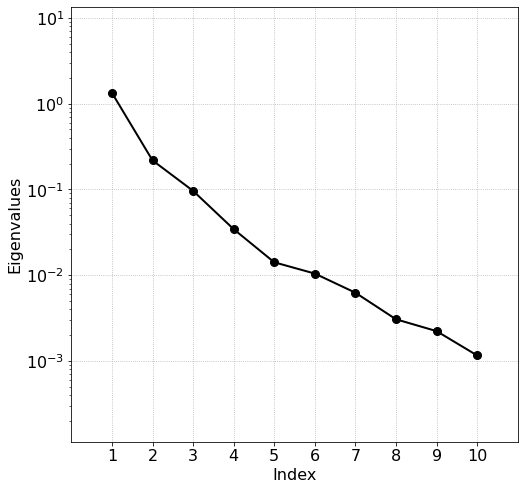

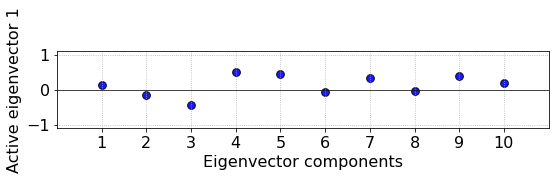

In [7]:
#vectorial AS
vss = ActiveSubspaces()
vss.compute( inputs=x, outputs=f, gradients=df, metric=metric, nboot=10)
vss.partition(5)
np.save("05_SPDE/modes_AS", vss.W1)
vss.partition(1)
vss.plot_eigenvalues()
vss.plot_eigenvectors()

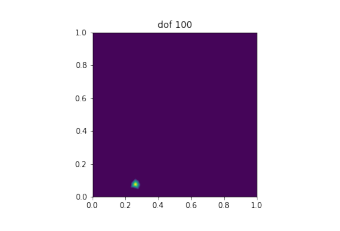

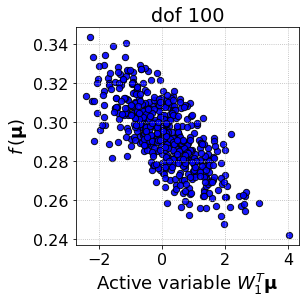

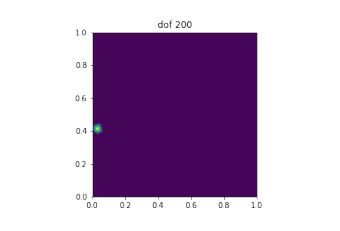

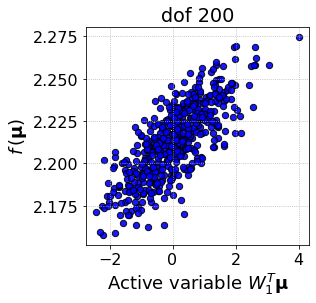

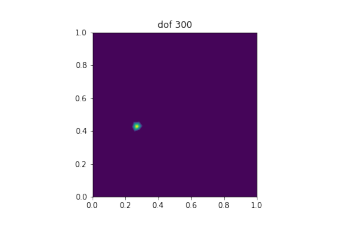

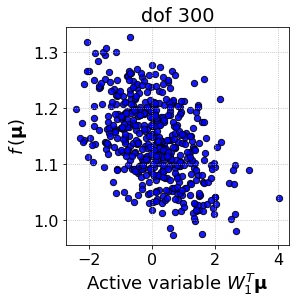

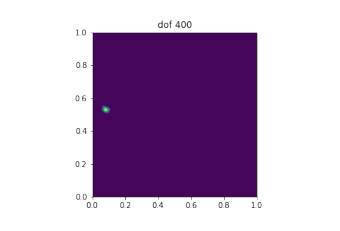

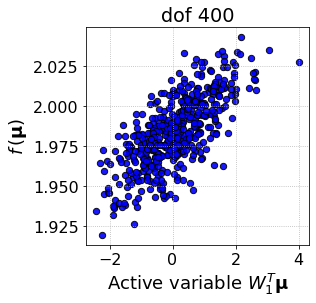

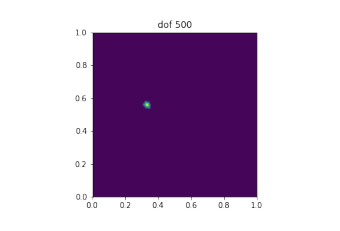

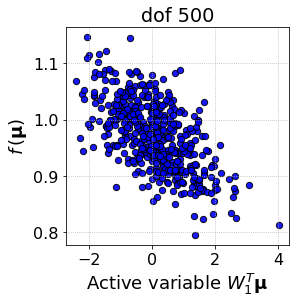

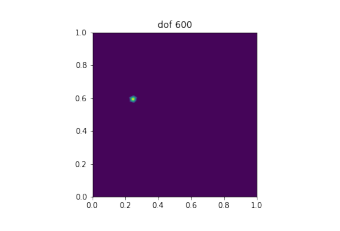

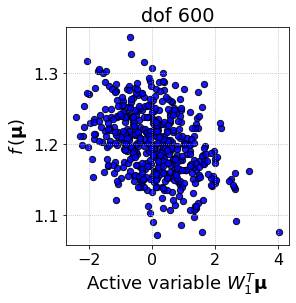

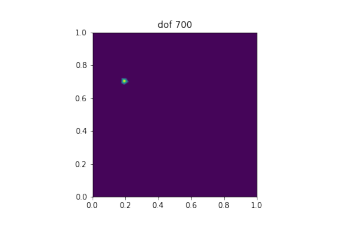

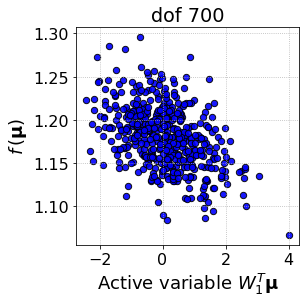

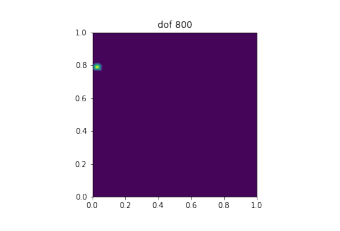

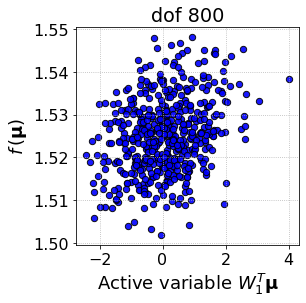

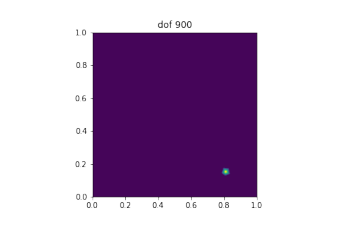

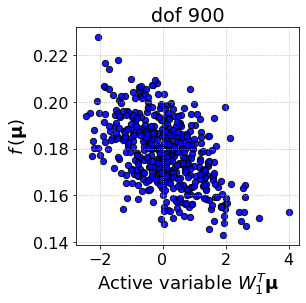

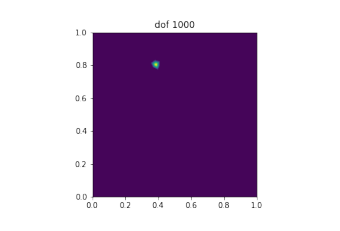

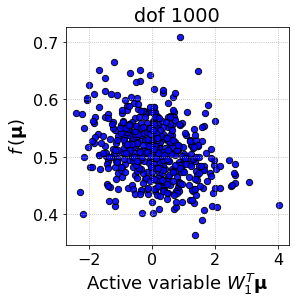

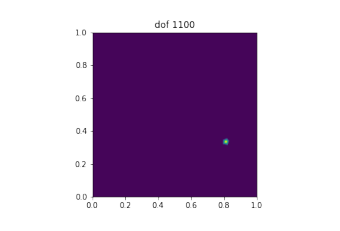

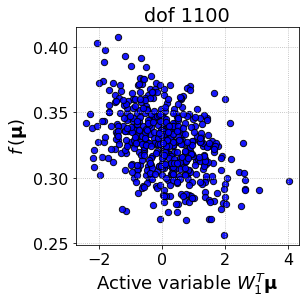

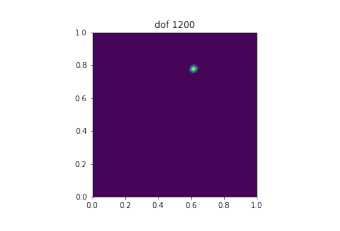

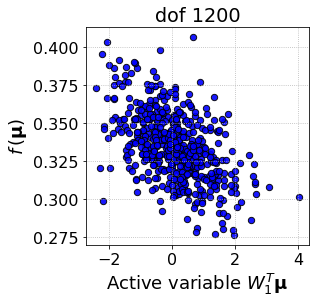

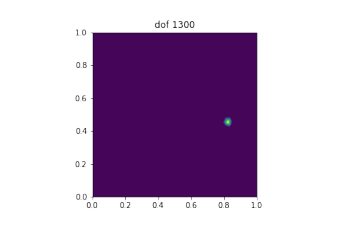

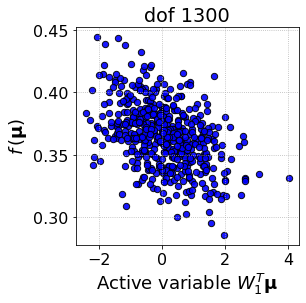

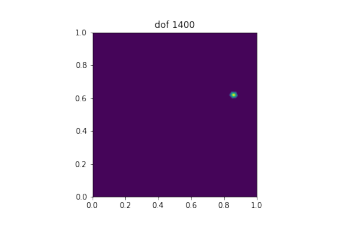

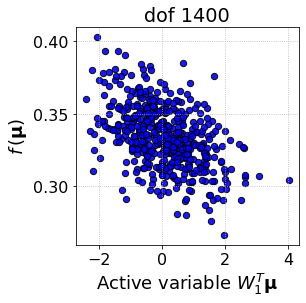

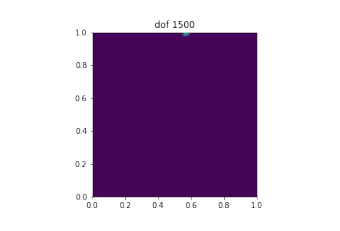

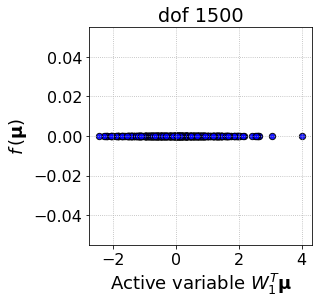

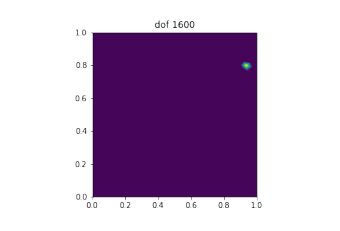

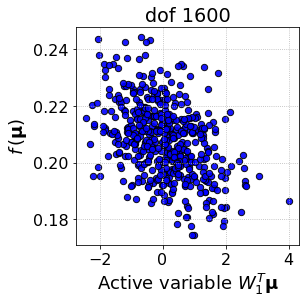

In [8]:
components = [100+j*100 for j in range(16)]
for i in components:
    img = mpimg.imread("05_SPDE/component_{}.png".format(i))
    plt.imshow(img)
    plt.axis('off')
    vss.plot_sufficient_summary(inputs=x, outputs=f[:, i], title="dof {}".format(i), figsize=(4,4))